# SAINT Transformer + H2O AutoML Multiplier Prediction

This notebook implements a hybrid approach using:
1. **SAINT Transformer**: Self-Attention and Intersample Attention Transformer for sequence embeddings
2. **Contrastive Learning**: Triplet loss training to learn meaningful sequence representations
3. **H2O AutoML**: Automated machine learning on embeddings for final predictions
4. **Range Estimation**: Uses training error distribution for prediction intervals

**Architecture:**
- Sequence length: 30
- Transformer generates embeddings for each sequence
- H2O AutoML automatically selects best model to predict multiplier from embeddings
- Range prediction based on error statistics


In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import h2o
from h2o.automl import H2OAutoML
import joblib
import warnings
import os
import time
import json
from datetime import datetime
from typing import Tuple, List, Dict, Optional
import random
from collections import defaultdict
warnings.filterwarnings('ignore')

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")

# Configuration
DATA_FOLDER = 'data'
CSV_FILE = os.path.join(DATA_FOLDER, 'aviator_payouts_global.csv')
SEQ_LENGTH = 30  # Sequence length
EMBEDDING_DIM = 128  # Embedding dimension
MODEL_DIR = 'saint_models'
os.makedirs(MODEL_DIR, exist_ok=True)
PREDICTION_LOG_FILE = 'saint_h2o_predictions_log.csv'

print(f"📁 CSV File: {CSV_FILE}")
print(f"📊 Sequence Length: {SEQ_LENGTH}")
print(f"🔢 Embedding Dimension: {EMBEDDING_DIM}")


✅ Using device: cpu
📁 CSV File: data/aviator_payouts_global.csv
📊 Sequence Length: 30
🔢 Embedding Dimension: 128


## 1. Data Loading and Sequence Preparation


In [5]:
# Load and prepare data
def load_csv_data(csv_path: str) -> pd.DataFrame:
    """Load and preprocess CSV data."""
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV file not found: {csv_path}")
    
    df = pd.read_csv(csv_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp').reset_index(drop=True)
    
    # Validate multipliers
    df['multiplier'] = pd.to_numeric(df['multiplier'], errors='coerce')
    df = df[df['multiplier'] >= 1.0]
    df = df.dropna().reset_index(drop=True)
    
    return df

# Load data
df = load_csv_data(CSV_FILE)
print(f"✅ Loaded {len(df)} records")
print(f"📅 Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"📊 Multiplier statistics:")
print(df['multiplier'].describe())

# Prepare sequences and targets
def prepare_sequences(df: pd.DataFrame, seq_length: int = 30) -> Tuple[np.ndarray, np.ndarray]:
    """
    Prepare sequences of length seq_length and corresponding targets (next value).
    
    Returns:
        sequences: (n_samples, seq_length) array
        targets: (n_samples,) array
    """
    multipliers = df['multiplier'].values
    sequences = []
    targets = []
    
    for i in range(seq_length, len(multipliers)):
        seq = multipliers[i - seq_length:i]
        target = multipliers[i]
        sequences.append(seq)
        targets.append(target)
    
    return np.array(sequences), np.array(targets)

sequences, targets = prepare_sequences(df, SEQ_LENGTH)
print(f"\n✅ Prepared {len(sequences)} sequences of length {SEQ_LENGTH}")
print(f"   Sequences shape: {sequences.shape}")
print(f"   Targets shape: {targets.shape}")

# Normalize sequences (helps with training stability)
sequence_scaler = RobustScaler()
# Reshape for scaling: (n_samples * seq_length, 1)
sequences_flat = sequences.reshape(-1, 1)
sequences_scaled_flat = sequence_scaler.fit_transform(sequences_flat)
sequences_scaled = sequences_scaled_flat.reshape(sequences.shape)

print(f"✅ Sequences normalized for training")


✅ Loaded 8456 records
📅 Date range: 2025-12-10 19:32:35 to 2025-12-13 15:56:36
📊 Multiplier statistics:
count    8456.000000
mean       10.861961
std       115.966587
min         1.000000
25%         1.290000
50%         1.930000
75%         3.800000
max      6114.720000
Name: multiplier, dtype: float64

✅ Prepared 8426 sequences of length 30
   Sequences shape: (8426, 30)
   Targets shape: (8426,)
✅ Sequences normalized for training


## 2. SAINT Transformer Architecture


In [6]:
class SAINTTransformer(nn.Module):
    """
    SAINT (Self-Attention and Intersample Attention Transformer) model
    for time series sequence embedding.
    """
    
    def __init__(
        self,
        input_dim: int = 1,  # Single value per timestep (multiplier)
        d_model: int = 128,
        nhead: int = 8,
        num_layers: int = 4,
        dim_feedforward: int = 512,
        dropout: float = 0.1,
        seq_length: int = 30
    ):
        super(SAINTTransformer, self).__init__()
        
        self.d_model = d_model
        self.seq_length = seq_length
        
        # Input projection: multiplier -> d_model
        self.input_projection = nn.Linear(input_dim, d_model)
        
        # Positional encoding (learnable)
        self.pos_encoder = nn.Parameter(torch.randn(1, seq_length, d_model))
        
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Pooling to get sequence embedding (mean + max pooling)
        self.pool_proj = nn.Linear(d_model * 2, d_model)
        
        # Layer normalization
        self.layer_norm = nn.LayerNorm(d_model)
        
    def forward(self, x):
        """
        Args:
            x: (batch_size, seq_length, input_dim) or (batch_size, seq_length)
        
        Returns:
            embeddings: (batch_size, d_model)
        """
        # Handle 2D input (batch_size, seq_length)
        if len(x.shape) == 2:
            x = x.unsqueeze(-1)  # (batch_size, seq_length, 1)
        
        batch_size, seq_len, _ = x.shape
        
        # Project input to d_model
        x = self.input_projection(x)  # (batch_size, seq_length, d_model)
        
        # Add positional encoding
        pos_enc = self.pos_encoder[:, :seq_len, :]
        x = x + pos_enc
        
        # Transformer encoding
        x = self.transformer(x)  # (batch_size, seq_length, d_model)
        
        # Pooling: mean and max
        mean_pool = x.mean(dim=1)  # (batch_size, d_model)
        max_pool = x.max(dim=1)[0]  # (batch_size, d_model)
        pooled = torch.cat([mean_pool, max_pool], dim=-1)  # (batch_size, 2*d_model)
        
        # Project pooled representation
        embedding = self.pool_proj(pooled)  # (batch_size, d_model)
        embedding = self.layer_norm(embedding)
        
        return embedding

# Test model
test_model = SAINTTransformer(
    input_dim=1,
    d_model=EMBEDDING_DIM,
    nhead=8,
    num_layers=4,
    dim_feedforward=512,
    dropout=0.1,
    seq_length=SEQ_LENGTH
).to(device)

test_input = torch.randn(4, SEQ_LENGTH).to(device)
test_output = test_model(test_input)
print(f"✅ SAINT Transformer model created")
print(f"   Input shape: {test_input.shape}")
print(f"   Output embedding shape: {test_output.shape}")
print(f"   Model parameters: {sum(p.numel() for p in test_model.parameters()):,}")


✅ SAINT Transformer model created
   Input shape: torch.Size([4, 30])
   Output embedding shape: torch.Size([4, 128])
   Model parameters: 830,336


In [7]:
def create_triplets(
    sequences: np.ndarray,
    targets: np.ndarray,
    n_triplets: int = 10000,
    margin: float = 0.1
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Create triplets for contrastive learning.
    Anchor: random sequence
    Positive: sequence with similar target (within margin)
    Negative: sequence with different target (outside margin)
    
    Args:
        sequences: (n_samples, seq_length)
        targets: (n_samples,)
        n_triplets: Number of triplets to generate
        margin: Margin for similarity (positive within margin, negative outside)
    
    Returns:
        anchors, positives, negatives: Each (n_triplets, seq_length)
    """
    n_samples = len(sequences)
    
    # Normalize targets for similarity calculation
    target_mean = targets.mean()
    target_std = targets.std()
    normalized_targets = (targets - target_mean) / (target_std + 1e-8)
    
    anchors = []
    positives = []
    negatives = []
    
    for _ in range(n_triplets):
        # Random anchor
        anchor_idx = np.random.randint(0, n_samples)
        anchor = sequences[anchor_idx]
        anchor_target_norm = normalized_targets[anchor_idx]
        
        # Find positive (similar target)
        target_diff = np.abs(normalized_targets - anchor_target_norm)
        positive_candidates = np.where(target_diff < margin)[0]
        
        if len(positive_candidates) > 1:
            # Exclude anchor itself
            positive_candidates = positive_candidates[positive_candidates != anchor_idx]
        
        if len(positive_candidates) > 0:
            positive_idx = np.random.choice(positive_candidates)
            positive = sequences[positive_idx]
        else:
            # If no positive found, use anchor (same sequence)
            positive = anchor
        
        # Find negative (different target)
        negative_candidates = np.where(target_diff > margin * 2)[0]
        
        if len(negative_candidates) > 0:
            negative_idx = np.random.choice(negative_candidates)
            negative = sequences[negative_idx]
        else:
            # If no negative found, use random different sequence
            negative_idx = np.random.randint(0, n_samples)
            while negative_idx == anchor_idx:
                negative_idx = np.random.randint(0, n_samples)
            negative = sequences[negative_idx]
        
        anchors.append(anchor)
        positives.append(positive)
        negatives.append(negative)
    
    return np.array(anchors), np.array(positives), np.array(negatives)

# Create triplets
print("🔄 Generating triplets for contrastive learning...")
triplet_anchors, triplet_positives, triplet_negatives = create_triplets(
    sequences, targets, n_triplets=min(10000, len(sequences) // 2), margin=0.1
)
print(f"✅ Generated {len(triplet_anchors)} triplets")
print(f"   Anchors shape: {triplet_anchors.shape}")
print(f"   Positives shape: {triplet_positives.shape}")
print(f"   Negatives shape: {triplet_negatives.shape}")


🔄 Generating triplets for contrastive learning...
✅ Generated 4213 triplets
   Anchors shape: (4213, 30)
   Positives shape: (4213, 30)
   Negatives shape: (4213, 30)


In [8]:
class TripletLoss(nn.Module):
    """Triplet loss for contrastive learning."""
    
    def __init__(self, margin: float = 1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
    
    def forward(self, anchor_emb, positive_emb, negative_emb):
        """
        Compute triplet loss.
        Loss = max(0, margin + d(anchor, positive) - d(anchor, negative))
        """
        # Euclidean distance
        pos_dist = torch.norm(anchor_emb - positive_emb, p=2, dim=1)
        neg_dist = torch.norm(anchor_emb - negative_emb, p=2, dim=1)
        
        loss = torch.clamp(self.margin + pos_dist - neg_dist, min=0.0)
        return loss.mean()

class SequenceDataset(Dataset):
    """Dataset for sequences."""
    
    def __init__(self, sequences: np.ndarray, targets: Optional[np.ndarray] = None):
        self.sequences = sequences
        self.targets = targets
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq = torch.FloatTensor(self.sequences[idx])
        if self.targets is not None:
            target = torch.FloatTensor([self.targets[idx]])
            return seq, target
        return seq

class TripletDataset(Dataset):
    """Dataset for triplet contrastive learning."""
    
    def __init__(self, anchors: np.ndarray, positives: np.ndarray, negatives: np.ndarray):
        self.anchors = anchors
        self.positives = positives
        self.negatives = negatives
    
    def __len__(self):
        return len(self.anchors)
    
    def __getitem__(self, idx):
        anchor = torch.FloatTensor(self.anchors[idx])
        positive = torch.FloatTensor(self.positives[idx])
        negative = torch.FloatTensor(self.negatives[idx])
        return anchor, positive, negative

print("✅ Loss functions and datasets created")


✅ Loss functions and datasets created


## 5. Train SAINT Transformer with Contrastive Learning


In [9]:
train_idx, test_idx = train_test_split(
    np.arange(len(sequences)), test_size=0.2, random_state=42
)

train_sequences = sequences[train_idx]
train_targets = targets[train_idx]
test_sequences = sequences[test_idx]
test_targets = targets[test_idx]

print(f"✅ Data split:")
print(f"   Train: {len(train_sequences)} sequences")
print(f"   Test: {len(test_sequences)} sequences")

✅ Data split:
   Train: 6740 sequences
   Test: 1686 sequences


🚀 Training SAINT Transformer with contrastive learning...
Epoch [5/30] - Loss: 0.9717
Epoch [10/30] - Loss: 0.9427
Epoch [15/30] - Loss: 0.9998
Epoch [20/30] - Loss: 0.9987
Epoch [25/30] - Loss: 1.0037
Epoch [30/30] - Loss: 0.9968
✅ Training completed!


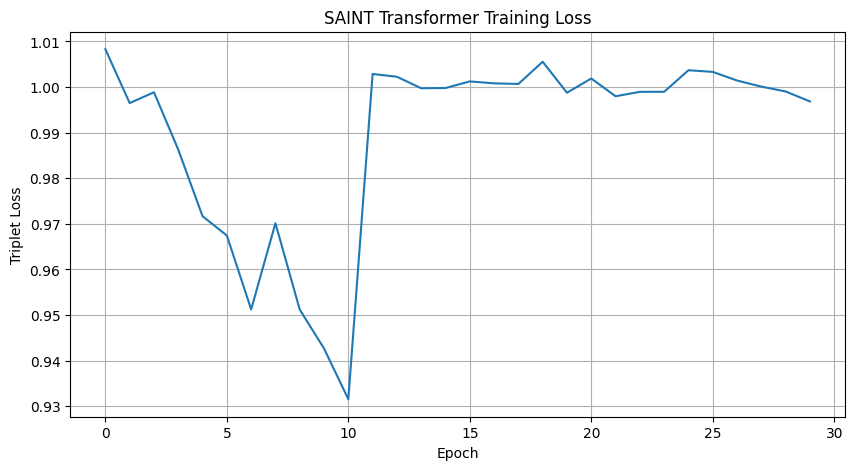

💾 Model saved to saint_models/saint_transformer.pth


In [7]:
# Split data


# Create triplets for training
train_anchors, train_positives, train_negatives = create_triplets(
    train_sequences, train_targets, n_triplets=min(5000, len(train_sequences) // 2), margin=0.1
)

# Create datasets and loaders
triplet_dataset = TripletDataset(train_anchors, train_positives, train_negatives)
triplet_loader = DataLoader(triplet_dataset, batch_size=64, shuffle=True, num_workers=0)

# Initialize model
model = SAINTTransformer(
    input_dim=1,
    d_model=EMBEDDING_DIM,
    nhead=8,
    num_layers=4,
    dim_feedforward=512,
    dropout=0.1,
    seq_length=SEQ_LENGTH
).to(device)

# Loss and optimizer
triplet_loss_fn = TripletLoss(margin=1.0)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training
num_epochs = 30
train_losses = []

print("🚀 Training SAINT Transformer with contrastive learning...")
print("=" * 60)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    
    for anchor, positive, negative in triplet_loader:
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)
        
        # Get embeddings
        anchor_emb = model(anchor)
        positive_emb = model(positive)
        negative_emb = model(negative)
        
        # Compute loss
        loss = triplet_loss_fn(anchor_emb, positive_emb, negative_emb)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
    
    epoch_loss /= len(triplet_loader)
    train_losses.append(epoch_loss)
    scheduler.step(epoch_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}")

print("=" * 60)
print("✅ Training completed!")

# Plot training curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Triplet Loss')
plt.title('SAINT Transformer Training Loss')
plt.grid(True)
plt.show()

# Save model
model_path = os.path.join(MODEL_DIR, 'saint_transformer.pth')
torch.save({
    'model_state_dict': model.state_dict(),
    'epoch': num_epochs,
    'losses': train_losses,
    'embedding_dim': EMBEDDING_DIM,
    'seq_length': SEQ_LENGTH
}, model_path)
print(f"💾 Model saved to {model_path}")


## 6. Load SAINT Model (or Use Trained Model)

Load a previously trained SAINT model or use the one just trained.


In [11]:
def load_saint_model(
    model_path: str,
    embedding_dim: int = 128,
    seq_length: int = 30,
    device: torch.device = None
) -> Tuple[nn.Module, Dict]:
    """
    Load a saved SAINT transformer model.
    
    Args:
        model_path: Path to saved model checkpoint (.pth file)
        embedding_dim: Embedding dimension (must match saved model)
        seq_length: Sequence length (must match saved model)
        device: Device to load model on
    
    Returns:
        model: Loaded SAINT transformer model
        metadata: Dictionary with model metadata (epoch, losses, etc.)
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}")
    
    print(f"📂 Loading SAINT model from {model_path}...")
    
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    
    # Extract metadata
    metadata = {
        'epoch': checkpoint.get('epoch', 'unknown'),
        'losses': checkpoint.get('losses', []),
        'embedding_dim': checkpoint.get('embedding_dim', embedding_dim),
        'seq_length': checkpoint.get('seq_length', seq_length)
    }
    
    # Use metadata from checkpoint if available
    saved_embedding_dim = checkpoint.get('embedding_dim', embedding_dim)
    saved_seq_length = checkpoint.get('seq_length', seq_length)
    
    if saved_embedding_dim != embedding_dim or saved_seq_length != seq_length:
        print(f"⚠️  Warning: Model config mismatch!")
        print(f"   Saved: embedding_dim={saved_embedding_dim}, seq_length={saved_seq_length}")
        print(f"   Requested: embedding_dim={embedding_dim}, seq_length={seq_length}")
        print(f"   Using saved configuration...")
        embedding_dim = saved_embedding_dim
        seq_length = saved_seq_length
    
    # Create model with correct architecture
    model = SAINTTransformer(
        input_dim=1,
        d_model=embedding_dim,
        nhead=8,
        num_layers=4,
        dim_feedforward=512,
        dropout=0.1,
        seq_length=seq_length
    ).to(device)
    
    # Load state dict
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set to evaluation mode
    
    print(f"✅ Model loaded successfully!")
    print(f"   Embedding dimension: {embedding_dim}")
    print(f"   Sequence length: {seq_length}")
    print(f"   Trained for {metadata['epoch']} epochs")
    if metadata['losses']:
        final_loss = metadata['losses'][-1] if len(metadata['losses']) > 0 else 'unknown'
        print(f"   Final training loss: {final_loss:.4f}")
    
    return model, metadata

# Load model (use existing trained model or load from file)
USE_SAVED_MODEL = True  # Set to True to load from file instead of using trained model
SAVED_MODEL_PATH = os.path.join(MODEL_DIR, 'saint_transformer.pth')

if USE_SAVED_MODEL and os.path.exists(SAVED_MODEL_PATH):
    print("📂 Loading saved SAINT model...")
    model, model_metadata = load_saint_model(
        SAVED_MODEL_PATH,
        embedding_dim=EMBEDDING_DIM,
        seq_length=SEQ_LENGTH,
        device=device
    )
else:
    print("✅ Using model trained in previous cell")
    print(f"   If you want to load a saved model, set USE_SAVED_MODEL = True")

print("✅ Model ready for embedding generation")


📂 Loading saved SAINT model...
📂 Loading SAINT model from saint_models/saint_transformer.pth...
✅ Model loaded successfully!
   Embedding dimension: 128
   Sequence length: 30
   Trained for 30 epochs
   Final training loss: 0.9968
✅ Model ready for embedding generation


## 7. Generate Embeddings for All Sequences


In [12]:


def generate_embeddings(model: nn.Module, sequences: np.ndarray, batch_size: int = 64) -> np.ndarray:
    """Generate embeddings for sequences."""
    model.eval()
    embeddings = []
    
    dataset = SequenceDataset(sequences)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    with torch.no_grad():
        for seq in loader:
            seq = seq.to(device)
            emb = model(seq)
            embeddings.append(emb.cpu().numpy())
    
    return np.vstack(embeddings)

print("🔄 Generating embeddings for all sequences...")
train_embeddings = generate_embeddings(model, train_sequences)
test_embeddings = generate_embeddings(model, test_sequences)

print(f"✅ Embeddings generated")
print(f"   Train embeddings shape: {train_embeddings.shape}")
print(f"   Test embeddings shape: {test_embeddings.shape}")

# Normalize embeddings
#scaler_emb = RobustScaler()
#train_embeddings_scaled = scaler_emb.fit_transform(train_embeddings)
#test_embeddings_scaled = scaler_emb.transform(test_embeddings)

#print(f"✅ Embeddings normalized")


🔄 Generating embeddings for all sequences...
✅ Embeddings generated
   Train embeddings shape: (6740, 128)
   Test embeddings shape: (1686, 128)


In [14]:
train_embeddings[:1]

array([[ 0.397898  ,  0.9836996 ,  0.26774585,  0.7750549 , -1.0427008 ,
        -1.5197794 ,  1.1700953 , -1.090172  ,  1.1549479 , -1.0115873 ,
         0.19170561, -1.537496  ,  1.2620208 ,  1.4258355 ,  1.1259812 ,
        -0.04365579, -0.52612525,  0.20863263, -2.0629413 ,  0.3007243 ,
        -0.8357707 ,  0.8672385 ,  0.8415024 , -0.8743257 , -0.44643804,
         0.9991053 ,  0.85994846,  0.5151596 ,  0.27635747,  0.89943546,
        -0.19760697, -1.4107217 , -1.0876284 ,  1.0972923 , -0.39371356,
        -0.93267894, -0.11407819,  0.05019319,  1.188981  ,  0.36422288,
        -1.471313  ,  0.05734245,  0.54997945, -0.87672037,  1.831751  ,
        -0.51988405,  0.07858109,  0.53403294, -2.0153687 , -0.45656174,
         0.7098797 ,  0.36024442,  0.2770832 , -0.01594323, -0.30616444,
        -1.59741   , -0.04890328,  0.50467503,  0.2864102 ,  1.0326341 ,
         0.37261078, -0.34440392, -0.49209663,  0.9401851 , -1.5685843 ,
         1.645008  , -1.2720462 ,  1.1400148 , -1.7

## 7. Train H2O AutoML Model


In [16]:
import h2o
h2o.init(max_mem_size="8G", nthreads=-1)

import pandas as pd

X=np.concatenate([train_embeddings, test_embeddings], axis=0)
y=np.concatenate([train_targets, test_targets], axis=0)

feature_names = [f"f_{i}" for i in range(X.shape[1])]

df = pd.DataFrame(X, columns=feature_names)
df["target"] = y

hf = h2o.H2OFrame(df)


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "25.0.1" 2025-10-21; OpenJDK Runtime Environment Homebrew (build 25.0.1); OpenJDK 64-Bit Server VM Homebrew (build 25.0.1, mixed mode, sharing)
  Starting server from /usr/local/Caskroom/miniconda/base/envs/aviator/lib/python3.12/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/6c/ff6r44ps7yz46qjlbjy3q2d80000gn/T/tmpdav7wgwk
  JVM stdout: /var/folders/6c/ff6r44ps7yz46qjlbjy3q2d80000gn/T/tmpdav7wgwk/h2o_traveller_started_from_python.out
  JVM stderr: /var/folders/6c/ff6r44ps7yz46qjlbjy3q2d80000gn/T/tmpdav7wgwk/h2o_traveller_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,19 days
H2O_cluster_name:,H2O_from_python_traveller_71hfe8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.984 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [17]:
from h2o.automl import H2OAutoML

aml = H2OAutoML(
    max_runtime_secs=600,   # 10 minutes
    max_models=25,
    seed=42,
    sort_metric="RMSE"
)

aml.train(
    x=feature_names,
    y="target",
    training_frame=hf
)


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_1_AutoML_1_20251214_01131


GLM Model: summary
    family    link      regularization             lambda_search                                                                number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  -------------------------  ---------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  --------------------------------------------------------------------------------------
    gaussian  identity  Ridge ( lambda = 47.859 )  nlambda = 30, lambda.max = 47.859, lambda.min = 47.859, lambda.1se = 47.859  128                           128                            1                       AutoML_1_20251214_01131_training_Key_Frame__upload_b51921ec730d459de79be3609e94fdc.hex

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 13490.10077197039
RMSE: 116.14689307928298
MAE: 15.123743328649049
RMSLE: 1.3924603087264045
Mean Residual Deviance: 13490.10077197039
R^2: 7.3901790164088155e-06
Null degrees of freedom: 8425
Residual degrees of freedom: 8297
Null deviance: 113668429.13466145
Residual deviance: 113667589.10462251
AIC: 104300.78058056776

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 13493.560133526691
RMSE: 116.16178430760561
MAE: 15.122109108648385
RMSLE: 1.3921488499337584
Mean Residual Deviance: 13493.560133526691
R^2: -0.00024904496921274166
Null degrees of freedom: 8425
Residual degrees of freedom: 8297
Null deviance: 113679481.03315145
Residual deviance: 113696737.68509589
AIC: 104302.9410420956

Cross-Validation Metrics Summary: 
                        mean          sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ------------  -----------  ------------  ------------  ------------  ------------  ------------
aic                     20813.1       1038.73      20499.9       19730.8       21986.2       21831.4       20017.3
loglikelihood           0             0            0             0             0             0             0
mae                     15.1222       1.52296      14.1298       13.9347       14.8771       17.7279       14.9417
mean_residual_deviance  13494         8143.11      9573.98       6109.01       23295.7       21250.5       7240.96
mse                     13494         8143.11      9573.98       6109.01       23295.7       21250.5       7240.96
null_deviance           2.27359e+07   1.37162e+07  1.61409e+07   1.02931e+07   3.92491e+07   3.57954e+07   1.2201e+07
r2                      -0.000380497  0.000396287  -0.000203859  -0.000641739  -0.000110057  -0.000941559  -5.26978e-06
residual_deviance       2.27393e+07   1.372e+07    1.61417e+07   1.02937e+07   3.92532e+07   3.58071e+07   1.2201e+07
rmse                    111.901       34.8599      97.8467       78.1602       152.629       145.776       85.0938
rmsle                   1.39207       0.0164409    1.39558       1.40892       1.38558       1.36716       1.40313

Scoring History: 
    timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_xval    deviance_se    alpha    iterations    training_rmse       training_deviance    training_mae        training_r2
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------  -------------  -------  ------------  ------------------  -------------------  ------------------  ----------------------
    2025-12-14 00:11:55  0.000 sec   1            48        129           13490.1           13494            3641.71        0
    2025-12-14 00:11:55  0.012 sec   2            30        129           13490.1           0                0              0        2             116.14689307928298  13490.10077197039    15.12374332864

In [18]:
print(aml.leaderboard.head())

leader = aml.leader


model_id                                                rmse      mse      mae      rmsle    mean_residual_deviance
GLM_1_AutoML_1_20251214_01131                        116.162  13493.6  15.1221    1.39215                   13493.6
DeepLearning_grid_1_AutoML_1_20251214_01131_model_1  116.194  13501    14.3435  nan                         13501
DeepLearning_1_AutoML_1_20251214_01131               116.34   13534.9  13.2877  nan                         13534.9
GBM_1_AutoML_1_20251214_01131                        116.467  13564.6  15.4667  nan                         13564.6
XGBoost_grid_1_AutoML_1_20251214_01131_model_4       116.555  13585.1  14.7622  nan                         13585.1
GBM_2_AutoML_1_20251214_01131                        117.74   13862.8  16.2772  nan                         13862.8
GBM_grid_1_AutoML_1_20251214_01131_model_2           117.818  13881.1  17.4008  nan                         13881.1
GBM_3_AutoML_1_20251214_01131                        118.202  13971.7  16.

In [19]:
perf = leader.model_performance(hf)

print("RMSE:", perf.rmse())
print("MAE :", perf.mae())
print("R2  :", perf.r2())


RMSE: 116.14689307928298
MAE : 15.123743328649049
R2  : 7.3901790164088155e-06


In [20]:
# Initialize H2O
print("🚀 Initializing H2O...")
try:
    h2o.cluster().shutdown()
except:
    pass
h2o.init(ip="localhost", port=54321, nthreads=-1, max_mem_size="4G")
h2o.no_progress()  # Disable progress bars for cleaner output

# Prepare data for H2O
print("📊 Preparing data for H2O AutoML...")

# Create DataFrames with embeddings and targets
train_df_h2o = pd.DataFrame(
    train_embeddings_scaled,
    columns=[f'emb_{i}' for i in range(train_embeddings_scaled.shape[1])]
)
train_df_h2o['target'] = train_targets

test_df_h2o = pd.DataFrame(
    test_embeddings_scaled,
    columns=[f'emb_{i}' for i in range(test_embeddings_scaled.shape[1])]
)
test_df_h2o['target'] = test_targets

# Convert to H2O Frames
train_h2o = h2o.H2OFrame(train_df_h2o)
test_h2o = h2o.H2OFrame(test_df_h2o)

# Set target column
target = 'target'
feature_cols = [f'emb_{i}' for i in range(train_embeddings_scaled.shape[1])]

print(f"✅ Data prepared:")
print(f"   Train samples: {train_h2o.nrows}")
print(f"   Test samples: {test_h2o.nrows}")
print(f"   Features: {len(feature_cols)}")

# Configure H2O AutoML
print("\\n🚀 Training H2O AutoML model...")
print("=" * 60)

aml = H2OAutoML(
    max_models=20,  # Maximum number of models
    max_runtime_secs=600,  # Maximum runtime in seconds (10 minutes)
    seed=42,
    sort_metric="MAE",  # Sort by Mean Absolute Error
    stopping_metric="MAE",
    stopping_tolerance=0.001,
    stopping_rounds=5,
    balance_classes=False,
    exclude_algos=[],  # Include all algorithms
    verbosity="info"
)

# Train AutoML
aml.train(
    x=feature_cols,
    y=target,
    training_frame=train_h2o,
    validation_frame=test_h2o
)

print("=" * 60)
print("✅ H2O AutoML training completed!")

# Display leaderboard
print("\\n📋 Model Leaderboard:")
print(aml.leaderboard.as_data_frame().head(10))

# Get best model
best_model = aml.leader
print(f"\\n🏆 Best Model: {best_model.model_id}")
print(f"   Model Type: {type(best_model).__name__}")

# Save model
h2o_model_path = os.path.join(MODEL_DIR, 'h2o_automl_model')
model_path_best = h2o.save_model(model=best_model, path=h2o_model_path, force=True)
print(f"💾 H2O model saved to: {model_path_best}")

# Save AutoML object info
h2o_info = {
    'best_model_id': best_model.model_id,
    'best_model_type': type(best_model).__name__,
    'leaderboard': aml.leaderboard.as_data_frame().to_dict('records')[:5]  # Top 5 models
}

with open(os.path.join(MODEL_DIR, 'h2o_model_info.json'), 'w') as f:
    json.dump(h2o_info, f, indent=2, default=str)
print(f"💾 Model info saved to: {os.path.join(MODEL_DIR, 'h2o_model_info.json')}")


🚀 Initializing H2O...
H2O session _sid_9459 closed.
Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,14 mins 11 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,19 days
H2O_cluster_name:,H2O_from_python_traveller_71hfe8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.897 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


📊 Preparing data for H2O AutoML...


NameError: name 'train_embeddings_scaled' is not defined

## 8. Evaluate H2O AutoML Performance Metrics


In [1]:
# Make predictions using H2O best model
print("📊 Making predictions...")

# Predictions on train set
train_pred_h2o = best_model.predict(train_h2o).as_data_frame()['predict'].values
train_pred = np.maximum(1.0, train_pred_h2o)  # Ensure >= 1.0

# Predictions on test set
test_pred_h2o = best_model.predict(test_h2o).as_data_frame()['predict'].values
test_pred = np.maximum(1.0, test_pred_h2o)  # Ensure >= 1.0

print("✅ Predictions completed")

# Calculate metrics
train_mae = mean_absolute_error(train_targets, train_pred)
train_rmse = np.sqrt(mean_squared_error(train_targets, train_pred))
train_r2 = r2_score(train_targets, train_pred)
train_mape = np.mean(np.abs((train_targets - train_pred) / train_targets)) * 100

test_mae = mean_absolute_error(test_targets, test_pred)
test_rmse = np.sqrt(mean_squared_error(test_targets, test_pred))
test_r2 = r2_score(test_targets, test_pred)
test_mape = np.mean(np.abs((test_targets - test_pred) / test_targets)) * 100

# Asymmetric error analysis
train_error = train_pred - train_targets
test_error = test_pred - test_targets

train_over_pred = np.mean(train_error[train_error > 0])  # Average over-prediction
train_under_pred = np.mean(np.abs(train_error[train_error < 0]))  # Average under-prediction
test_over_pred = np.mean(test_error[test_error > 0])
test_under_pred = np.mean(np.abs(test_error[test_error < 0]))

print("=" * 80)
print("📊 PERFORMANCE METRICS")
print("=" * 80)
print(f"\n📈 TRAIN SET:")
print(f"   MAE: {train_mae:.4f}")
print(f"   RMSE: {train_rmse:.4f}")
print(f"   R²: {train_r2:.4f}")
print(f"   MAPE: {train_mape:.2f}%")
print(f"   Avg Over-prediction: {train_over_pred:.4f}")
print(f"   Avg Under-prediction: {train_under_pred:.4f}")

print(f"\n📊 TEST SET:")
print(f"   MAE: {test_mae:.4f}")
print(f"   RMSE: {test_rmse:.4f}")
print(f"   R²: {test_r2:.4f}")
print(f"   MAPE: {test_mape:.2f}%")
print(f"   Avg Over-prediction: {test_over_pred:.4f}")
print(f"   Avg Under-prediction: {test_under_pred:.4f}")
print("=" * 80)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Scatter plots
axes[0, 0].scatter(train_targets, train_pred, alpha=0.5, s=10)
axes[0, 0].plot([train_targets.min(), train_targets.max()], 
                [train_targets.min(), train_targets.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual')
axes[0, 0].set_ylabel('Predicted')
axes[0, 0].set_title(f'Train Set (R² = {train_r2:.4f})')
axes[0, 0].grid(True)

axes[0, 1].scatter(test_targets, test_pred, alpha=0.5, s=10)
axes[0, 1].plot([test_targets.min(), test_targets.max()], 
                [test_targets.min(), test_targets.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual')
axes[0, 1].set_ylabel('Predicted')
axes[0, 1].set_title(f'Test Set (R² = {test_r2:.4f})')
axes[0, 1].grid(True)

# Residual plots
axes[1, 0].scatter(train_pred, train_error, alpha=0.5, s=10)
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].set_title('Train Residuals')
axes[1, 0].grid(True)

axes[1, 1].scatter(test_pred, test_error, alpha=0.5, s=10)
axes[1, 1].axhline(y=0, color='r', linestyle='--')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].set_title('Test Residuals')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Error distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(train_error, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Error (Predicted - Actual)')
plt.ylabel('Frequency')
plt.title('Train Error Distribution')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(test_error, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Error (Predicted - Actual)')
plt.ylabel('Frequency')
plt.title('Test Error Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Store error statistics for range prediction
train_error_stats = {
    'mean': np.mean(train_error),
    'std': np.std(train_error),
    'p5': np.percentile(train_error, 5),
    'p95': np.percentile(train_error, 95),
    'over_pred_mean': train_over_pred,
    'under_pred_mean': train_under_pred
}

print(f"\n📊 Error Statistics (for range prediction):")
print(f"   Mean: {train_error_stats['mean']:.4f}")
print(f"   Std: {train_error_stats['std']:.4f}")
print(f"   5th percentile: {train_error_stats['p5']:.4f}")
print(f"   95th percentile: {train_error_stats['p95']:.4f}")

# Save error stats
error_stats_path = os.path.join(MODEL_DIR, 'error_stats.json')
with open(error_stats_path, 'w') as f:
    json.dump({k: float(v) for k, v in train_error_stats.items()}, f, indent=2)
print(f"💾 Error statistics saved to {error_stats_path}")


📊 Making predictions...


NameError: name 'best_model' is not defined

## 9. Prediction Pipeline with Range Estimation


## 10. Monitoring Pipeline for Live Predictions


In [ ]:
class SAINTH2OPredictor:
    """Complete prediction pipeline: Sequence -> Embedding -> H2O AutoML -> Prediction + Range"""
    
    def __init__(
        self,
        model: nn.Module,
        h2o_model,
        scaler_emb: RobustScaler,
        error_stats: Dict,
        seq_length: int = 30,
        device: torch.device = None
    ):
        self.model = model
        self.h2o_model = h2o_model
        self.scaler_emb = scaler_emb
        self.error_stats = error_stats
        self.seq_length = seq_length
        self.device = device if device is not None else torch.device('cpu')
        self.model.eval()
        
        # Feature column names for H2O
        self.feature_cols = [f'emb_{i}' for i in range(scaler_emb.n_features_in_)]
    
    def predict(
        self,
        sequence: np.ndarray,
        confidence: float = 0.95
    ) -> Dict:
        """
        Predict multiplier and range from sequence.
        
        Args:
            sequence: (seq_length,) array of multipliers
            confidence: Confidence level for range (default 0.95)
        
        Returns:
            Dictionary with prediction, range_min, range_max, etc.
        """
        # Ensure sequence is correct length
        if len(sequence) != self.seq_length:
            raise ValueError(f"Sequence must be length {self.seq_length}, got {len(sequence)}")
        
        # Generate embedding
        seq_tensor = torch.FloatTensor(sequence).unsqueeze(0).to(self.device)
        with torch.no_grad():
            embedding = self.model(seq_tensor).cpu().numpy()
        
        # Scale embedding
        embedding_scaled = self.scaler_emb.transform(embedding)
        
        # Convert to H2O Frame
        pred_df = pd.DataFrame(
            embedding_scaled,
            columns=self.feature_cols
        )
        pred_h2o = h2o.H2OFrame(pred_df)
        
        # Predict multiplier
        prediction_h2o = self.h2o_model.predict(pred_h2o).as_data_frame()['predict'].values[0]
        prediction = max(1.0, float(prediction_h2o))  # Ensure >= 1.0
        
        # Calculate range based on error statistics
        # Use asymmetric range: wider on positive side (over-prediction)
        error_std = self.error_stats['std']
        
        # Lower bound: use lower percentile (more conservative)
        lower_bound = prediction + self.error_stats['p5']
        lower_bound = max(1.0, lower_bound)  # Ensure >= 1.0
        
        # Upper bound: use higher percentile with more penalty for over-prediction
        # Since we penalize over-prediction more, make upper bound wider
        upper_bound = prediction + self.error_stats['p95'] * 1.2  # 20% wider for safety
        upper_bound = max(prediction, upper_bound)  # At least as high as prediction
        
        return {
            'prediction': float(prediction),
            'range_min': float(lower_bound),
            'range_max': float(upper_bound),
            'confidence': confidence
        }
    
    def predict_batch(self, sequences: np.ndarray, confidence: float = 0.95) -> List[Dict]:
        """Predict for multiple sequences."""
        results = []
        for seq in sequences:
            results.append(self.predict(seq, confidence))
        return results

# Initialize predictor
predictor = SAINTH2OPredictor(
    model=model,
    h2o_model=best_model,
    scaler_emb=scaler_emb,
    error_stats=train_error_stats,
    seq_length=SEQ_LENGTH,
    device=device
)

print("✅ Prediction pipeline created")

# Test on a few sequences
print("\n🧪 Testing prediction pipeline...")
test_seqs = test_sequences[:5]
test_actuals = test_targets[:5]

for i, (seq, actual) in enumerate(zip(test_seqs, test_actuals)):
    result = predictor.predict(seq)
    error = result['prediction'] - actual
    in_range = (result['range_min'] <= actual <= result['range_max'])
    
    print(f"\nSequence {i+1}:")
    print(f"  Actual: {actual:.4f}x")
    print(f"  Predicted: {result['prediction']:.4f}x")
    print(f"  Range: {result['range_min']:.4f}x - {result['range_max']:.4f}x")
    print(f"  Error: {error:+.4f}")
    print(f"  In Range: {'✅' if in_range else '❌'}")

# Calculate range coverage on test set
test_results = predictor.predict_batch(test_sequences[:100])  # Sample for speed
test_range_coverage = sum(
    1 for i, res in enumerate(test_results)
    if res['range_min'] <= test_targets[i] <= res['range_max']
) / len(test_results) * 100

print(f"\n📊 Range Coverage (first 100 test samples): {test_range_coverage:.1f}%")


## 11. Save Complete Pipeline


In [ ]:
# Initialize prediction log
prediction_log = []
pending_prediction_index = None
pending_prediction_data = None

def save_prediction_log():
    """Save prediction log to CSV."""
    if len(prediction_log) == 0:
        return
    log_df = pd.DataFrame(prediction_log)
    log_df.to_csv(PREDICTION_LOG_FILE, index=False)
    print(f"💾 Prediction log saved to {PREDICTION_LOG_FILE}")

def get_sequence_for_prediction(df: pd.DataFrame, index: int, seq_length: int = 30) -> Optional[np.ndarray]:
    """Get sequence ending at index for prediction."""
    if index < seq_length:
        return None
    seq = df['multiplier'].iloc[index - seq_length:index].values
    return seq

def monitor_and_predict(check_interval: float = 2.0, max_iterations: Optional[int] = None):
    """
    Monitor CSV for new data and make predictions using SAINT + H2O AutoML pipeline.
    
    Workflow:
    1. Read CSV in loop
    2. On new data:
       - If no pending prediction -> predict for next index, store index
       - If pending prediction -> check stored index, print actual, then predict next
    """
    global df, prediction_log, pending_prediction_index, pending_prediction_data
    
    # Start from the last row we have data for
    last_known_row = len(df) - 1
    iteration = 0
    
    print("=" * 80)
    print("🚀 Starting SAINT + H2O AutoML Prediction Agent")
    print("=" * 80)
    print(f"📁 Monitoring: {CSV_FILE}")
    print(f"⏱️  Check interval: {check_interval} seconds")
    print(f"🔄 Starting from row {last_known_row} (last known index: {last_known_row})")
    print("=" * 80)
    print("\\nPress Ctrl+C to stop\\n")
    
    try:
        while True:
            if max_iterations and iteration >= max_iterations:
                break
            
            # Load current CSV
            try:
                current_df = load_csv_data(CSV_FILE)
            except Exception as e:
                print(f"⚠️  Error loading CSV: {e}")
                time.sleep(check_interval)
                continue
            
            current_row_count = len(current_df)
            
            # Check if we have new data
            if current_row_count > last_known_row + 1:
                new_rows_count = current_row_count - (last_known_row + 1)
                print(f"\\n📈 New data detected: {new_rows_count} new row(s) (Total: {current_row_count}, Last known: {last_known_row})")
                
                # Update df
                df = current_df
                
                # Case 1: We have a pending prediction - check if actual is now available
                if pending_prediction_index is not None:
                    if pending_prediction_index < len(df):
                        # Actual value is now available!
                        actual_value = float(df['multiplier'].iloc[pending_prediction_index])
                        actual_timestamp = df['timestamp'].iloc[pending_prediction_index]
                        
                        pred_value = pending_prediction_data['prediction']
                        pred_min = pending_prediction_data['range_min']
                        pred_max = pending_prediction_data['range_max']
                        
                        # Calculate errors
                        error = actual_value - pred_value
                        abs_error = abs(error)
                        pct_error = abs(error / actual_value * 100) if actual_value > 0 else 0
                        in_range = (pred_min <= actual_value <= pred_max)
                        
                        # Print actual value
                        print("\\n" + "=" * 80)
                        print("✅ ACTUAL MULTIPLIER")
                        print("=" * 80)
                        print(f"📊 Index: {pending_prediction_index}")
                        print(f"📊 Actual Multiplier: {actual_value:.4f}x")
                        print(f"🔮 Predicted: {pred_value:.4f}x")
                        print(f"📏 Range: {pred_min:.4f}x - {pred_max:.4f}x")
                        print(f"❌ Error: {error:+.4f} ({pct_error:.2f}%)")
                        print(f"{'✅' if in_range else '❌'} In Range: {in_range}")
                        print(f"⏰ Timestamp: {actual_timestamp}")
                        print("=" * 80)
                        
                        # Update log entry
                        if len(prediction_log) > 0:
                            log_entry = prediction_log[-1]
                            log_entry['actual_value'] = actual_value
                            log_entry['actual_timestamp'] = actual_timestamp.isoformat() if hasattr(actual_timestamp, 'isoformat') else str(actual_timestamp)
                            log_entry['error'] = error
                            log_entry['abs_error'] = abs_error
                            log_entry['pct_error'] = pct_error
                            log_entry['in_range'] = in_range
                            log_entry['status'] = 'completed'
                        
                        # Save log
                        save_prediction_log()
                        
                        # Store index and clear pending
                        processed_index = pending_prediction_index
                        pending_prediction_index = None
                        pending_prediction_data = None
                        last_known_row = processed_index
                
                # Case 2: No pending prediction OR we just processed one -> make new prediction
                if pending_prediction_index is None:
                    next_prediction_index = last_known_row + 1
                    
                    # Check if we have enough data
                    if len(df) < SEQ_LENGTH + 1:
                        print(f"⚠️  Insufficient data for prediction (need {SEQ_LENGTH + 1}, have {len(df)})")
                        last_known_row = current_row_count - 1
                        time.sleep(check_interval)
                        iteration += 1
                        continue
                    
                    # Get sequence for prediction
                    sequence = get_sequence_for_prediction(df, next_prediction_index, SEQ_LENGTH)
                    
                    if sequence is None:
                        print(f"⚠️  Could not get sequence for index {next_prediction_index}")
                        last_known_row = current_row_count - 1
                        time.sleep(check_interval)
                        iteration += 1
                        continue
                    
                    # Make prediction
                    print(f"🔮 Making prediction for index {next_prediction_index}...")
                    try:
                        result = predictor.predict(sequence)
                        
                        pred_value = result['prediction']
                        pred_min = result['range_min']
                        pred_max = result['range_max']
                        
                        # Print prediction FIRST
                        print("\\n" + "=" * 80)
                        print("🔮 PREDICTION")
                        print("=" * 80)
                        print(f"📊 Predicting for index: {next_prediction_index}")
                        print(f"📊 Predicted Multiplier: {pred_value:.4f}x")
                        print(f"📏 Range: {pred_min:.4f}x - {pred_max:.4f}x")
                        print(f"⏰ Timestamp: {datetime.now().isoformat()}")
                        print("=" * 80)
                        print(f"\\n⏳ Waiting for actual multiplier at index {next_prediction_index}...")
                        
                        # Save prediction
                        log_entry = {
                            'prediction_index': next_prediction_index,
                            'prediction_timestamp': datetime.now().isoformat(),
                            'predicted_value': pred_value,
                            'range_min': pred_min,
                            'range_max': pred_max,
                            'actual_value': None,
                            'actual_timestamp': None,
                            'error': None,
                            'abs_error': None,
                            'pct_error': None,
                            'in_range': None,
                            'status': 'pending'
                        }
                        
                        prediction_log.append(log_entry)
                        
                        # Store pending prediction
                        pending_prediction_index = next_prediction_index
                        pending_prediction_data = result
                        
                    except Exception as e:
                        print(f"⚠️  Error making prediction: {e}")
                        last_known_row = current_row_count - 1
            else:
                # No new data
                time.sleep(check_interval)
            
            iteration += 1
            
    except KeyboardInterrupt:
        print("\\n\\n⏹️  Monitoring stopped by user")
        print("\\n📊 Final Statistics:")
        if len(prediction_log) > 0:
            completed = [p for p in prediction_log if p['status'] == 'completed']
            if len(completed) > 0:
                completed_df = pd.DataFrame(completed)
                print(f"   Total predictions: {len(prediction_log)}")
                print(f"   Completed: {len(completed)}")
                print(f"   Pending: {len(prediction_log) - len(completed)}")
                print(f"   Average absolute error: {completed_df['abs_error'].mean():.4f}")
                print(f"   Average percentage error: {completed_df['pct_error'].mean():.2f}%")
                print(f"   Range coverage: {(completed_df['in_range'].sum() / len(completed) * 100):.1f}%")
        
        save_prediction_log()
        print(f"\\n✅ Prediction log saved to: {PREDICTION_LOG_FILE}")

print("✅ Monitoring function ready")
print("\\nTo start monitoring, run:")
print("monitor_and_predict(check_interval=2.0)")


In [ ]:
# Save complete pipeline metadata
pipeline_path = os.path.join(MODEL_DIR, 'complete_pipeline_metadata.json')
pipeline_metadata = {
    'saint_model_path': model_path,
    'h2o_model_path': model_path_best,
    'h2o_model_id': best_model.model_id,
    'h2o_model_type': type(best_model).__name__,
    'scaler_emb_path': os.path.join(MODEL_DIR, 'scaler_emb.pkl'),
    'error_stats_path': error_stats_path,
    'seq_length': SEQ_LENGTH,
    'embedding_dim': EMBEDDING_DIM,
    'test_metrics': {
        'mae': float(test_mae),
        'rmse': float(test_rmse),
        'r2': float(test_r2),
        'mape': float(test_mape)
    }
}

# Save scaler
import joblib
joblib.dump(scaler_emb, pipeline_metadata['scaler_emb_path'])

# Save metadata
with open(pipeline_path, 'w') as f:
    json.dump(pipeline_metadata, f, indent=2)
print(f"💾 Pipeline metadata saved to {pipeline_path}")

print("\\n" + "=" * 80)
print("✅ NOTEBOOK COMPLETE")
print("=" * 80)
print(f"📊 Model Performance:")
print(f"   Test MAE: {test_mae:.4f}")
print(f"   Test RMSE: {test_rmse:.4f}")
print(f"   Test R²: {test_r2:.4f}")
print(f"   Test MAPE: {test_mape:.2f}%")
print(f"\\n📁 Models saved in: {MODEL_DIR}")
print(f"📝 Prediction log: {PREDICTION_LOG_FILE}")
print("\\n🚀 Ready for monitoring!")


## 12. Start Monitoring (Live Predictions)

Run the cell below to start monitoring the CSV file:


In [ ]:
# Start monitoring
# Uncomment to start:
# monitor_and_predict(check_interval=2.0)

# Or with limited iterations for testing:
# monitor_and_predict(check_interval=2.0, max_iterations=10)

print("Ready to start monitoring. Uncomment the monitor_and_predict() call above.")
